# Data analysis: Covid cases over time

Data analysis of daily new covid cases in different countries, using data from:

https://github.com/CSSEGISandData/COVID-19

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
plt.style.use("ggplot")

## Import and clean up data

In [3]:
def read_csv(file, response):
    return (
        pd.read_csv(file)
        # Remove unused columns
        .drop(["Lat", "Long"], axis=1)
        # Make the date a column
        .melt(id_vars=["Province/State", "Country/Region"], var_name="Date", value_name=response)
        # Convert the date from string to a real date
        .assign(**{"Date": lambda df: pd.to_datetime(df["Date"])})
        # Aggregate provinces
        .groupby(["Country/Region", "Date"])
        .sum()
        # Convert cumulative totals to daily increments
        .groupby(level="Country/Region")
        .diff()
    )

In [4]:
cases_df = read_csv("time_series_covid19_confirmed_global.csv", "Cases")

In [5]:
cases_df.head(5)

Cases
Country/Region Date             
Afghanistan    2020-01-22    NaN
               2020-01-23    0.0
               2020-01-24    0.0
               2020-01-25    0.0
               2020-01-26    0.0

In [6]:
deaths_df = read_csv("time_series_covid19_deaths_global.csv", "Deaths")

In [7]:
deaths_df.head(5)

Deaths
Country/Region Date              
Afghanistan    2020-01-22     NaN
               2020-01-23     0.0
               2020-01-24     0.0
               2020-01-25     0.0
               2020-01-26     0.0

In [8]:
df = cases_df.join(deaths_df)

In [9]:
df.head(5)

Cases  Deaths
Country/Region Date                     
Afghanistan    2020-01-22    NaN     NaN
               2020-01-23    0.0     0.0
               2020-01-24    0.0     0.0
               2020-01-25    0.0     0.0
               2020-01-26    0.0     0.0

## Analyze

In [10]:
date_from = pd.to_datetime("2021-01-01")
date_to   = pd.to_datetime("2021-12-31")

countries = sorted([
    "Poland",
    "Czechia",
    "Germany",
    "Austria",
    "United Kingdom"
])

In [11]:
def plot(df):
    fig, ax = plt.subplots(figsize=(16,5))
    df.plot(ax=ax)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

### Plot cases day by day

In [12]:
cases_day_by_day = df.loc[(countries, slice(date_from, date_to)), "Cases"]
cases_day_by_day.groupby(level="Country/Region").head()

Country/Region  Date      
Austria         2021-01-01     2096.0
                2021-01-02     1391.0
                2021-01-03     1466.0
                2021-01-04     1642.0
                2021-01-05     2311.0
Czechia         2021-01-01    13361.0
                2021-01-02     3447.0
                2021-01-03     5012.0
                2021-01-04     6233.0
                2021-01-05    12921.0
Germany         2021-01-01    15575.0
                2021-01-02    11036.0
                2021-01-03    10356.0
                2021-01-04    12320.0
                2021-01-05    18349.0
Poland          2021-01-01    10896.0
                2021-01-02     7006.0
                2021-01-03     5782.0
                2021-01-04     4385.0
                2021-01-05     7596.0
United Kingdom  2021-01-01    53458.0
                2021-01-02    57853.0
                2021-01-03    55157.0
                2021-01-04    58923.0
                2021-01-05    61087.0
Name: Cases, dtype: flo

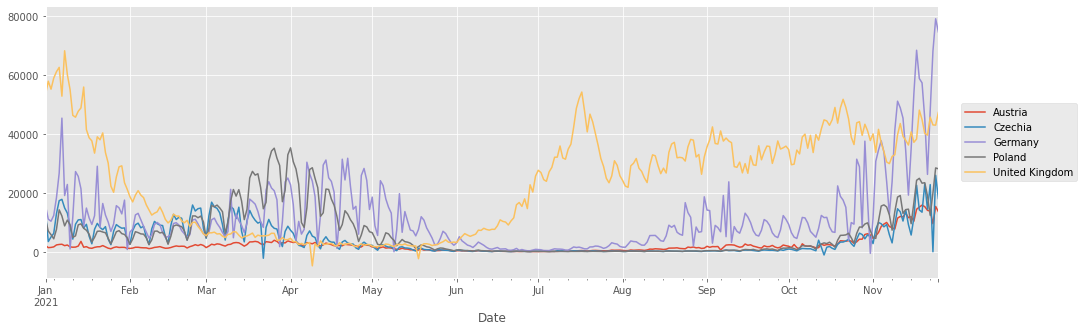

In [13]:
plot(cases_day_by_day.unstack(level="Country/Region"))

### Plot cases week-by-week

In [14]:
def week_start(dt):
    return dt - timedelta(days=dt.weekday())

In [15]:
cases_week_by_week = (
    cases_df.loc[(countries, slice(week_start(date_from), date_to)), "Cases"]
    .groupby(level="Country/Region")
    .resample("1W", level="Date")
    .sum()
)
cases_week_by_week.groupby(level="Country/Region").head()

Country/Region  Date      
Austria         2021-01-03     13876.0
                2021-01-10     14954.0
                2021-01-17     13056.0
                2021-01-24     10936.0
                2021-01-31      9684.0
Czechia         2021-01-03     69882.0
                2021-01-10     90684.0
                2021-01-17     57994.0
                2021-01-24     48458.0
                2021-01-31     47157.0
Germany         2021-01-03    125257.0
                2021-01-10    145514.0
                2021-01-17    120719.0
                2021-01-24     97640.0
                2021-01-31     77890.0
Poland          2021-01-03     60763.0
                2021-01-10     66960.0
                2021-01-17     50060.0
                2021-01-24     39863.0
                2021-01-31     37940.0
United Kingdom  2021-01-03    367471.0
                2021-01-10    418669.0
                2021-01-17    324372.0
                2021-01-24    252117.0
                2021-01-31    170326.

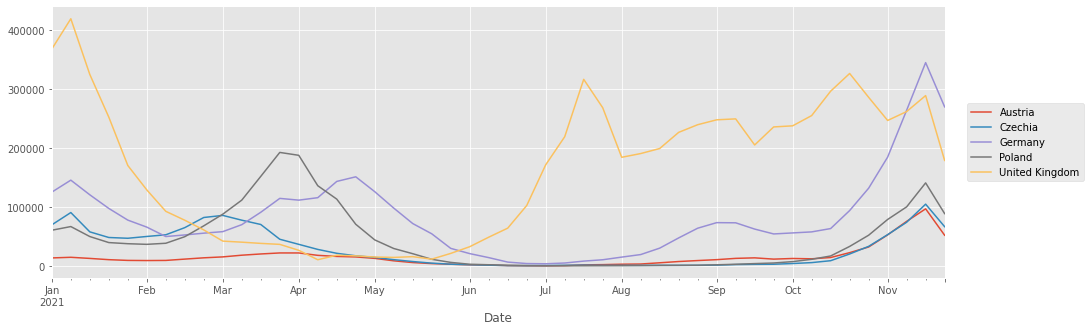

In [16]:
plot(cases_week_by_week.unstack(level="Country/Region"))

### Plot moving average of cases

In [17]:
def moving_average(df, window_days, date_from, date_to):
    return (
        df.loc[(slice(None), slice(date_from - timedelta(days=window_days-1), date_to)), :]
        .groupby(level="Country/Region")
        .apply(lambda s: s.rolling(7).sum())
        .loc[(countries, slice(date_from, date_to)), :]
    )

In [18]:
cases_moving_average = moving_average(df.loc[countries], 7, date_from, date_to)
cases_moving_average.groupby(level="Country/Region").head(10)

Cases  Deaths
Country/Region Date                        
Austria        2021-01-01   13856.0   478.0
               2021-01-02   13818.0   432.0
               2021-01-03   13876.0   443.0
               2021-01-04   13926.0   426.0
               2021-01-05   14369.0   398.0
               2021-01-06   14288.0   376.0
               2021-01-07   13915.0   346.0
               2021-01-08   13882.0   380.0
               2021-01-09   14769.0   412.0
               2021-01-10   14954.0   399.0
Czechia        2021-01-01   67159.0   852.0
               2021-01-02   67900.0   877.0
               2021-01-03   69882.0   916.0
               2021-01-04   72374.0   918.0
               2021-01-05   74433.0   955.0
               2021-01-06   75345.0  1007.0
               2021-01-07   76079.0  1041.0
               2021-01-08   77579.0  1089.0
               2021-01-09   87247.0  1151.0
               2021-01-10   90684.0  1155.0
Germany        2021-01-01  129768.0  4570.0
               2021-01-02  127300.0  4534.0
               2021-01-03  125257.0  4494.0
               2021-01-04  123573.0  4603.0
               2021-01-05  122810.0  4494.0
               2021-01-06  117532.0  4554.0
               2021-01-07  139632.0  5196.0
               2021-01-08  143134.0  5872.0
               2021-01-09  154922.0  6117.0
               2021-01-10  145514.0  6145.0
Poland         2021-01-01   56695.0  1964.0
               2021-01-02   58823.0  1997.0
               2021-01-03   60763.0  2001.0
               2021-01-04   61937.0  2014.0
               2021-01-05   61909.0  2048.0
               2021-01-06   63349.0  2036.0
               2021-01-07   62004.0  1687.0
               2021-01-08   59871.0  1618.0
               2021-01-09   63609.0  1953.0
               2021-01-10   66960.0  2070.0
United Kingdom 2021-01-01  321742.0  3935.0
               2021-01-02  344807.0  4169.0
               2021-01-03  367471.0  4277.0
               2021-01-04  384934.0  4330.0
               2021-01-05  392746.0  4753.0
               2021-01-06  405063.0  4813.0
               2021-01-07  401821.0  5010.0
               2021-01-08  416555.0  5728.0
               2021-01-09  418800.0  6318.0
               2021-01-10  418669.0  6430.0

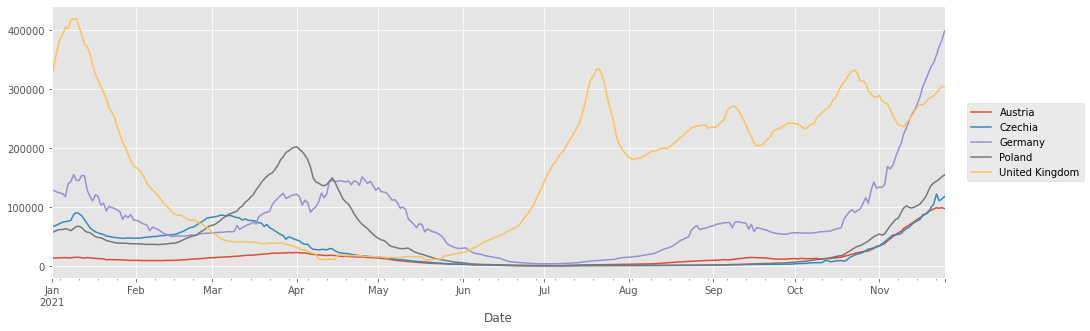

In [19]:
plot(cases_moving_average.loc[:, "Cases"].unstack(level="Country/Region"))

### Compare 2020 and 2021

In [20]:
def moving_average_year_to_year(df, window_days, years):
    return pd.concat(
        moving_average(df.loc[countries], window_days, pd.to_datetime(f"{year}-04-01"), pd.to_datetime(f"{year}-11-15"))
        .reset_index()
        .assign(**{"Year": year, "Day": lambda df: df["Date"].dt.strftime("%m-%d")})
        .drop(columns=["Date"])
        for year in years
    ).set_index(["Country/Region", "Year", "Day"]).sort_index()

In [21]:
cases_year_to_year = moving_average_year_to_year(df.loc[countries], window_days=7, years=[2020, 2021])
cases_year_to_year.groupby(["Country/Region", "Year"]).head(5)

Cases  Deaths
Country/Region Year Day                    
Austria        2020 04-01    5123.0   116.0
                    04-02    4220.0   109.0
                    04-03    3867.0   110.0
                    04-04    3510.0   118.0
                    04-05    3263.0   118.0
               2021 04-01   23199.0   190.0
                    04-02   22441.0   197.0
                    04-03   22226.0   203.0
                    04-04   22290.0   193.0
                    04-05   21431.0   207.0
Czechia        2020 04-01    1854.0    33.0
                    04-02    1933.0    35.0
                    04-03    1812.0    44.0
                    04-04    1841.0    48.0
                    04-05    1770.0    51.0
               2021 04-01   44256.0  1136.0
                    04-02   42558.0  1126.0
                    04-03   38713.0  1089.0
                    04-04   36867.0  1071.0
                    04-05   37048.0  1021.0
Germany        2020 04-01   40549.0   714.0
                    04-02   40856.0   840.0
                    04-03   40288.0   933.0
                    04-04   38397.0  1011.0
                    04-05   38028.0  1051.0
               2021 04-01  121715.0  1154.0
                    04-02  117059.0  1112.0
                    04-03  103104.0  1095.0
                    04-04  111677.0  1101.0
                    04-05  107360.0   997.0
Poland         2020 04-01    1503.0    29.0
                    04-02    1725.0    41.0
                    04-03    1994.0    55.0
                    04-04    1989.0    61.0
                    04-05    2240.0    72.0
               2021 04-01  202149.0  2805.0
                    04-02  197545.0  2860.0
                    04-03  193859.0  2984.0
                    04-04  187551.0  3057.0
                    04-05  180499.0  3073.0
United Kingdom 2020 04-01   25946.0  2426.0
                    04-02   27748.0  2901.0
                    04-03   29480.0  3350.0
                    04-04   30710.0  3815.0
                    04-05   31468.0  4203.0
               2021 04-01   31625.0   322.0
                    04-02   28812.0   303.0
                    04-03   28327.0   255.0
                    04-04   26785.0   244.0
                    04-05   24833.0   249.0

In [26]:
def plot_cases_year_to_year(df):
    countries, years, days = df.index.levels
    
    fig, axs = plt.subplots(nrows=len(countries), ncols=2, figsize=(16, 24))
    plt.subplots_adjust(hspace=0.45)
    
    for row, country in zip(axs, countries):
        for ax, response in zip(row, ["Cases", "Deaths"]):
            for year in years:
                cases = df.loc[(country, year)]
                ax.plot(cases.index, cases[response], label=year)

            ax.set_title(f"{country} - {response}")
            ax.set_xticks([day for day in days if day.endswith("-01")])
            ax.legend(loc="center", ncol=2, bbox_to_anchor=(0.5, -0.2))

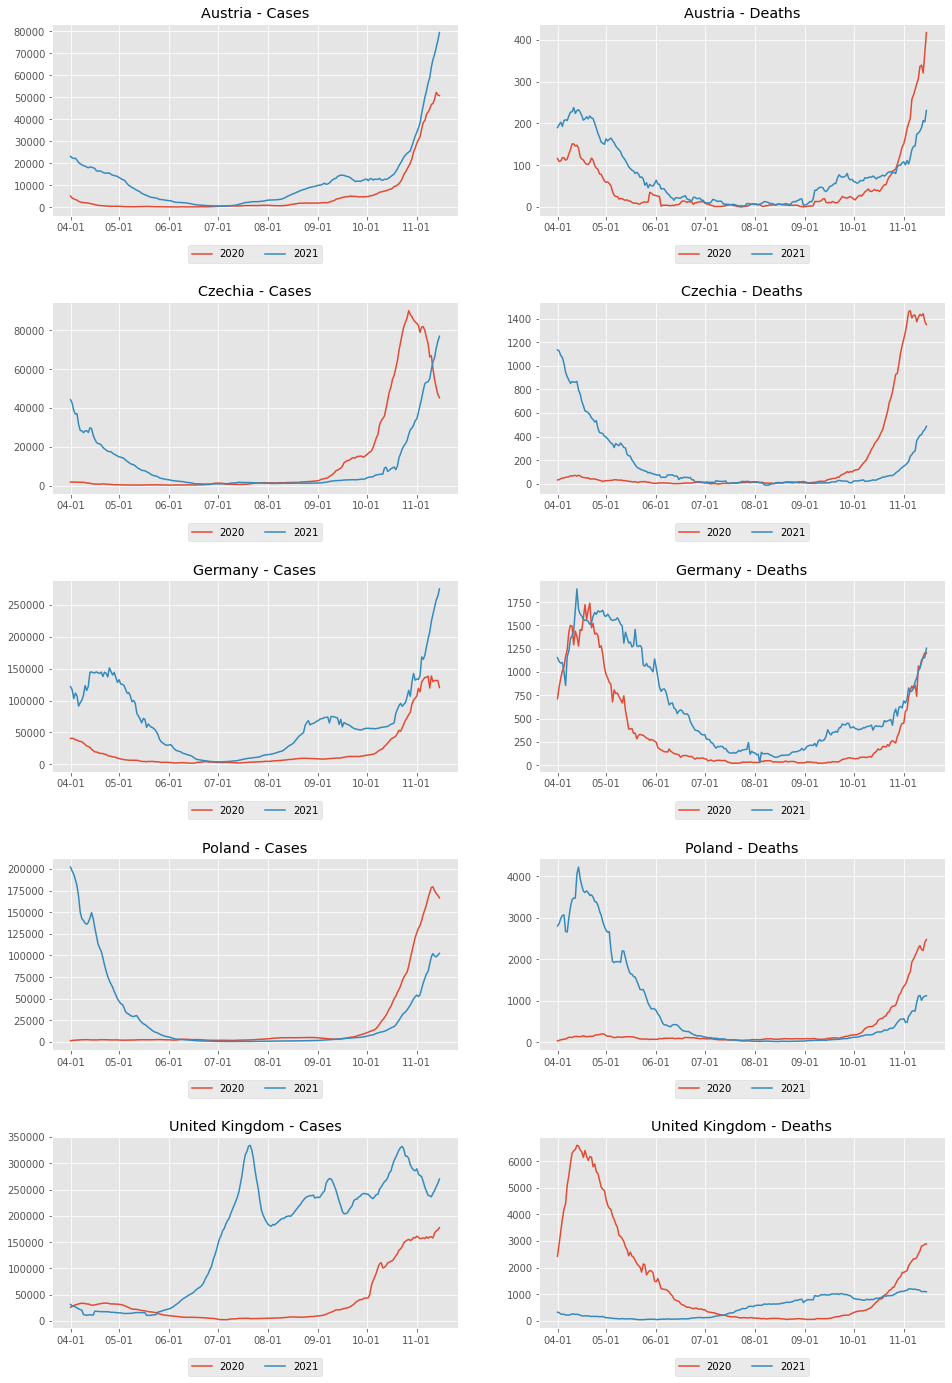

In [27]:
plot_cases_year_to_year(cases_year_to_year)